## Introduction

A couple of years back, I was pursuing an MBA degree in Shanghai, China. I had a business idea of opening a Turkish Fast Food restaurant chain that would rapidly grow into different parts of the country. Frankly, F&B was the only knowledge I thought we could sell to the rest of the world. Of course both Turkey and China being the hubs of no-value added goods had great influence on that. At the time, I had no clue on Data Science as the topic wasn’t this hot; so with a Chinese classmate, we started looking into the best products we can commercialize in a fast food restaurant, and came up with different ideas using fairly conventional techniques. At the end of the day, we concluded that there was almost no room for a lean start to this project as rent prices in Shanghai was nuts, to say the least. Put together with my family business concerns back home, we had to scrap the project without even igniting.

Four years later, when capstone project of IBM dictated using Foursquare API to call data from Foursquare database for a data science project, this was totally the first thing that came to my mind. I wondered if I could analyze the fast food restaurant environment in Shanghai to see where I could open a restaurant. This time though, limited data was a big obstacle, and as Chinese mostly don’t use Foursquare at all, my project would be a fruit of bunch of western tourists that wouldn’t reflect the real picture at all. Hence, I made Los Angeles, California, United States my new playground.


Before I start with the project, let me explain what methodology I will be following for this project. IBM has its own data science methodology that involves ten stations to deploy a data science report, which you can see below. As I have become very much familiar with this one throughout the course, I’ll try to follow it.

1. Business Understanding
2. Analytic Approach
3. Data Requirements
4. Data Collection
5. Data Understanding
6. Data Preperation
7. Modeling
8. Evaluation
9. Deployment
10.Feedback

##### Before diving into the project, let's download libraries that we will be using.

In [1]:
!pip install geopy

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 102kB 12.5MB/s ta 0:00:01
Libraries imported.


### 1. Business Understanding and Analytic Approach
I think what I would like to do is pretty much clear thanks to what I explained earlier, but to restate it one more time; I’m someone who wants to introduce a new fast food restaurant concept, and I would like to find which areas of Los Angeles are more suitable for this. One of the reasons why I was so confused while doing in Shanghai was that there was no way of knowing how scattered fast food restaurants in which areas of the city according to what terms. You can see this in LA as well in the below scatter plot among LA neighborhoods. 

### 2,3,4. Data Requirements, Data Collection, and Data Understanding

First of all, I need the names, coordinates, of all the neighborhoods in LA. Then, I need the ratio of fast food restaurants over other restaurants to see where fast food culture is better established. Then in order to have a better understanding of income levels of those areas, I need median rent prices for each neighborhood to see whether there is a correlation between fast food restaurant frequencies and rent prices, which I take as an income level indicator.

I basically have two data sources; one is USC Price Housing Price Open Data, where I have median rent prices between 2011-2016 indexed by neighborhood names. This data also includes coordinates for each specific neighborhood. Second data source is Foursquare, where I can import venue categories for different neighborhoods using their API.

As you can see in the below table, rent prices table have median housing prices for different locations in different neighborhood coordinates. On the other side, we make calls from Foursquare to get the top venue categories available around these coordinates. We set a limit to results and radius to cover to avoid confusion. I set them to 10k results and 10k meters radius. 


So let's start downloading data into a dataframes using Pandas library.

In [2]:
la_rent = pd.read_csv('RentPriceLA.csv')
la_rent.head()


Policy Area     Dataset           Variable  Year  Amount  \
0  Housing & Real Estate  Rent Price  Median Rent Price  2010  1236.0   
1  Housing & Real Estate  Rent Price  Median Rent Price  2010  1483.0   
2  Housing & Real Estate  Rent Price  Median Rent Price  2010  1086.0   
3  Housing & Real Estate  Rent Price  Median Rent Price  2010  1231.0   
4  Housing & Real Estate  Rent Price  Median Rent Price  2011  1391.0   

                                               Tract  Tract Number  \
0  Census Tract 1247, Los Angeles County, California        124700   
1  Census Tract 5038.01, Los Angeles County, Cali...        503801   
2  Census Tract 5739.02, Los Angeles County, Cali...        573902   
3  Census Tract 5766.02, Los Angeles County, Cali...        576602   
4  Census Tract 1247, Los Angeles County, California        124700   

   Neighborhood                 GEOID                              Location  \
0  Sherman Oaks  1400000US06037124700  (34.162466912294, -118.413864499994)   
1     La Mirada  1400000US06037503801       (33.899102856233, -117.9936485)   
2    Long Beach  1400000US06037573902       (33.8119735, -118.078652493167)   
3    Long Beach  1400000US06037576602  (33.765980150191, -118.170779302632)   
4  Sherman Oaks  1400000US06037124700  (34.162466912294, -118.413864499994)   

                                        Row ID        Date  
0  Median_Rent_Price_2010_1400000US06037124700  01/01/2010  
1  Median_Rent_Price_2010_1400000US06037503801  01/01/2010  
2  Median_Rent_Price_2010_1400000US06037573902  01/01/2010  
3  Median_Rent_Price_2010_1400000US06037576602  01/01/2010  
4  Median_Rent_Price_2011_1400000US06037124700  01/01/2011

In [3]:
# Let's see how many row we have in our rent prices data frame.
la_rent.shape

(16390, 12)

In [4]:
# Let's see what years are included in the data:
la_rent['Year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [5]:
# Let's change Amount column to Rent Price
la_rent = la_rent.rename(columns={'Amount': 'Rent Price'})

In [6]:
# Let's drop the unnecessary columns we won't be using. 
la_rent = la_rent.drop(['Policy Area','Variable','Tract','Tract Number','GEOID','Row ID','Date'], axis=1)
la_rent.head()

Dataset  Year  Rent Price  Neighborhood  \
0  Rent Price  2010      1236.0  Sherman Oaks   
1  Rent Price  2010      1483.0     La Mirada   
2  Rent Price  2010      1086.0    Long Beach   
3  Rent Price  2010      1231.0    Long Beach   
4  Rent Price  2011      1391.0  Sherman Oaks   

                               Location  
0  (34.162466912294, -118.413864499994)  
1       (33.899102856233, -117.9936485)  
2       (33.8119735, -118.078652493167)  
3  (33.765980150191, -118.170779302632)  
4  (34.162466912294, -118.413864499994)

In [7]:
#Let's seperate location data into latitude and longitude.
# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in la_rent['Location']:
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[0])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[1])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
la_rent['Latitude'] = lat
la_rent['Longitude'] = lon

In [8]:
# Removing brackets from coordinates.
la_rent['Latitude'] = la_rent['Latitude'].str.replace('(','')
la_rent['Longitude'] = la_rent['Longitude'].str.replace(')','')
la_rent.head()

Dataset  Year  Rent Price  Neighborhood  \
0  Rent Price  2010      1236.0  Sherman Oaks   
1  Rent Price  2010      1483.0     La Mirada   
2  Rent Price  2010      1086.0    Long Beach   
3  Rent Price  2010      1231.0    Long Beach   
4  Rent Price  2011      1391.0  Sherman Oaks   

                               Location         Latitude           Longitude  
0  (34.162466912294, -118.413864499994)  34.162466912294   -118.413864499994  
1       (33.899102856233, -117.9936485)  33.899102856233        -117.9936485  
2       (33.8119735, -118.078652493167)       33.8119735   -118.078652493167  
3  (33.765980150191, -118.170779302632)  33.765980150191   -118.170779302632  
4  (34.162466912294, -118.413864499994)  34.162466912294   -118.413864499994

In [9]:
# Dropping Location column that is no longer of use.
la_rent.drop(['Location'], axis=1, inplace=True)

In [10]:
la_rent.dropna(inplace=True)

In [11]:
# Changing data types of coordinates from object to float.
la_rent['Latitude'] = la_rent['Latitude'].astype(float)
la_rent['Longitude'] = la_rent['Longitude'].astype(float)

In [12]:
# Getting median house rent prices, coordinates, and year of data for each neighborhood.
la_rent_med = la_rent.groupby('Neighborhood').mean()
la_rent_med.head()

Year   Rent Price   Latitude   Longitude
Neighborhood                                                    
Acton            2012.583333  1647.500000  34.497483 -118.206372
Adams-Normandie  2013.000000   920.742857  34.031700 -118.299543
Agoura Hills     2012.900000  2052.500000  34.155534 -118.765098
Agua Dulce       2012.000000  1130.200000  34.514900 -118.307700
Alhambra         2013.000000  1205.564286  34.084448 -118.135322

In [13]:
# Resetting index names so we can plot the folium map. 
la_rent_med.reset_index(inplace=True)
la_rent_med.head()

Neighborhood         Year   Rent Price   Latitude   Longitude
0            Acton  2012.583333  1647.500000  34.497483 -118.206372
1  Adams-Normandie  2013.000000   920.742857  34.031700 -118.299543
2     Agoura Hills  2012.900000  2052.500000  34.155534 -118.765098
3       Agua Dulce  2012.000000  1130.200000  34.514900 -118.307700
4         Alhambra  2013.000000  1205.564286  34.084448 -118.135322

### Let's plot the map of Los Angeles with all neighboorhoods shown with blue markers.

In [14]:
#First we get the coordinates of Los Angeles, using Geocoder.
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


In [15]:
# We use folium library to visualize all the neighborhoods in Los Angeles on the map.

map_los_angeles = folium.Map(location=[latitude,longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(la_rent_med['Latitude'], la_rent_med['Longitude'], la_rent_med['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_los_angeles)  
    
map_los_angeles

#### In this report, we will be using Foursquare as another source of data. 
#### So, Foursquare API will be our middle man to gather all the data we need to forecast where to open our restaurant.

In [16]:
# Foursquare is charging for certain calls made over the API so even though we will be using the freemium version, we will need below keys to open the gate. 

CLIENT_ID = '5FGKFF5DNJTQAUSGV1VFXHIB1N5GUUGEE0ZNE2ILVKI34Y3J' # your Foursquare ID
CLIENT_SECRET = '25GZGU2WSFZTCSWIOA15Z32PAMDR22T3L52NBLWAJRS03CRL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 5FGKFF5DNJTQAUSGV1VFXHIB1N5GUUGEE0ZNE2ILVKI34Y3J
CLIENT_SECRET:25GZGU2WSFZTCSWIOA15Z32PAMDR22T3L52NBLWAJRS03CRL


In [17]:
#In order to concatenate housing and neighborhood dataset with venues data gathered from Foursquare API we need the following function:

LIMIT = 10000
Radius = 10000

def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',          
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
#Let's call all the new information available to a new dataset.
los_angeles_venues = getNearbyVenues(names=la_rent_med['Neighborhood'],
                                   latitudes=la_rent_med['Latitude'],
                                   longitudes=la_rent_med['Longitude']
                                  )

Acton
Adams-Normandie
Agoura Hills
Agua Dulce
Alhambra
Alondra Park
Altadena
Angeles Crest
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avalon
Avocado Heights
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bell
Bell Gardens
Bellflower
Beverly Crest
Beverly Grove
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brentwood
Broadway-Manchester
Burbank
Calabasas
Canoga Park
Carson
Carthay
Castaic
Castaic Canyons
Central-Alameda
Century City
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Chesterfield Square
Cheviot Hills
Chinatown
Citrus
Claremont
Commerce
Compton
Covina
Cudahy
Culver City
Cypress Park
Del Aire
Del Rey
Diamond Bar
Downey
Downtown
Duarte
Eagle Rock
East Compton
East Hollywood
East La Mirada
East Los Angeles
East Pasadena
East San Gabriel
Echo Park
El Monte
El Segundo
El Sereno
Elizabeth Lake
Elysian Park
Elysian Valley
Encino
Exposition Park
Fairfax
Florence
Florence-Firestone
Gardena
Glassell Park
Glendale
Glendora
Gramercy Park
Granada Hills
Gree

In [19]:
#Let's see how many rows and columns we have in our new dataset.
los_angeles_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        Acton              34.497483             -118.206372   
1        Acton              34.497483             -118.206372   
2        Acton              34.497483             -118.206372   
3        Acton              34.497483             -118.206372   
4        Acton              34.497483             -118.206372   

                          Venue  Venue Latitude  Venue Longitude  \
0  Acton Market & Country Store       34.468451      -118.197633   
1                  Animal Acres       34.495853      -118.222415   
2               Jack in the Box       34.492398      -118.199205   
3                     La Cabaña       34.479308      -118.166997   
4            Crazy Otto's Diner       34.490733      -118.162548   

         Venue Category  
0         Grocery Store  
1                  Farm  
2  Fast Food Restaurant  
3    Mexican Restaurant  
4        Breakfast Spot

In [20]:
los_angeles_venues.shape

(24928, 7)

In [21]:
#Let's group the total number of items we have in our dataset to have a better understanding of what we are dealing with.
#To clarify; radius will be limited to 10k meters, in order to keep things simple.
los_angeles_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                   
Acton                                                     23   
Adams-Normandie                                          100   
Agoura Hills                                             100   
Agua Dulce                                                15   
Alhambra                                                 100   
Alondra Park                                             100   
Altadena                                                 100   
Angeles Crest                                              5   
Arcadia                                                  100   
Arleta                                                   100   
Arlington Heights                                        100   
Artesia                                                  100   
Athens                                                   100   
Atwater Village                                          100   
Avalon                                                    56   
Avocado Heights                                          100   
Azusa                                                    100   
Baldwin Hills/Crenshaw                                   100   
Baldwin Park                                             100   
Bel-Air                                                  100   
Bell                                                     100   
Bell Gardens                                             100   
Bellflower                                               100   
Beverly Crest                                            100   
Beverly Grove                                            100   
Beverly Hills                                            100   
Beverlywood                                              100   
Boyle Heights                                            100   
Bradbury                                                 100   
Brentwood                                                100   
Broadway-Manchester                                      100   
Burbank                                                  100   
Calabasas                                                100   
Canoga Park                                              100   
Carson                                                   100   
Carthay                                                  100   
Castaic                                                  100   
Castaic Canyons                                           98   
Central-Alameda                                          100   
Century City                                             100   
Cerritos                                                 100   
Charter Oak                                              100   
Chatsworth                                               100   
Chatsworth Reservoir                                     100   
Chesterfield Square                                      100   
Cheviot Hills                                            100   
Chinatown                                                100   
Citrus                                                   100   
Claremont                                                100   
Commerce                                                 100   
Compton                                                  100   
Covina                                                   100   
Cudahy                                                   100   
Culver City                                              100   
Cypress Park                                             100   
Del Aire                                                 100   
Del Rey                                                  100   
Diamond Bar                                              100   
Downey                                                   100   
Downtown                                                 100   
Duarte                                                   100   
Eagle R

In [22]:
print('There are {} uniques categories.'.format(len(los_angeles_venues['Venue Category'].unique())))

There are 337 uniques categories.


In [23]:
# One hot encoding: we turn categorical values in to zeros and ones to better accomodate Machine Learning algorithms.
los_angeles_onehot = pd.get_dummies(los_angeles_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
los_angeles_onehot['Neighborhood'] = los_angeles_venues['Neighborhood'] 
los_angeles_onehot.set_index('Neighborhood', inplace = True)
los_angeles_onehot.reset_index(inplace=True)
los_angeles_onehot.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  Airport  \
0        Acton    0                  0               0        0   
1        Acton    0                  0               0        0   
2        Acton    0                  0               0        0   
3        Acton    0                  0               0        0   
4        Acton    0                  0               0        0   

   Airport Food Court  Airport Service  American Restaurant  Amphitheater  \
0                   0                0                    0             0   
1                   0                0                    0             0   
2                   0                0                    0             0   
3                   0                0                    0             0   
4                   0                0                    0             0   

   Animal Shelter  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0               0             0         0       0                       0   
1               0             0         0       0                       0   
2               0             0         0       0                       0   
3               0             0         0       0                       0   
4               0             0         0       0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0            0           0                    0                 0   
1            0           0                    0                 0   
2            0           0                    0                 0   
3            0           0                    0                 0   
4            0           0                    0                 0   

   Athletics & Sports  Australian Restaurant  Auto Dealership  Auto Garage  \
0                   0                      0                0            0   
1                   0                      0                0            0   
2                   0                      0                0            0   
3                   0                      0                0            0   
4                   0                      0                0            0   

   Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0                0          0           0       0     0    0               0   
1                0          0           0       0     0    0               0   
2                0          0           0       0     0    0               0   
3                0          0           0       0     0    0               0   
4                0          0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0                 0                 0                   0      0   
1                 0                 0                   0      0   
2                 0                 0                   0      0   
3                 0                 0                   0      0   
4                 0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Big Box Store  Bike Shop  Bistro  \
0                0         0            0              0          0       0   
1                0         0            0              0          0       0   
2                0         0            0              0          0       0   
3                0         0            0              0          0       0   
4                0         0            0              0          0       0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Boxing Gym  \
0              0          0         0              0           0   
1              0          0         0              0           0   
2              0          0         0              0           0   
3              0          0         0              0           0   
4              0          0         0              0           0   

   Brazilian Re

In [28]:
#Calculating frequencies of each category appearing in each neighbourhood.
los_angeles_grouped = los_angeles_onehot.groupby('Neighborhood').mean().reset_index()
los_angeles_grouped

Neighborhood       ATM  Accessories Store  \
0                                    Acton  0.000000               0.00   
1                          Adams-Normandie  0.000000               0.00   
2                             Agoura Hills  0.000000               0.00   
3                               Agua Dulce  0.000000               0.00   
4                                 Alhambra  0.000000               0.00   
5                             Alondra Park  0.000000               0.00   
6                                 Altadena  0.000000               0.00   
7                            Angeles Crest  0.000000               0.00   
8                                  Arcadia  0.000000               0.00   
9                                   Arleta  0.000000               0.00   
10                       Arlington Heights  0.000000               0.00   
11                                 Artesia  0.000000               0.00   
12                                  Athens  0.000000               0.00   
13                         Atwater Village  0.000000               0.00   
14                                  Avalon  0.017857               0.00   
15                         Avocado Heights  0.000000               0.00   
16                                   Azusa  0.000000               0.00   
17                  Baldwin Hills/Crenshaw  0.000000               0.00   
18                            Baldwin Park  0.000000               0.00   
19                                 Bel-Air  0.000000               0.00   
20                                    Bell  0.000000               0.01   
21                            Bell Gardens  0.000000               0.01   
22                              Bellflower  0.000000               0.00   
23                           Beverly Crest  0.000000               0.00   
24                           Beverly Grove  0.000000               0.00   
25                           Beverly Hills  0.000000               0.00   
26                             Beverlywood  0.000000               0.00   
27                           Boyle Heights  0.000000               0.00   
28                                Bradbury  0.000000               0.00   
29                               Brentwood  0.000000               0.00   
30                     Broadway-Manchester  0.000000               0.00   
31                                 Burbank  0.000000               0.00   
32                               Calabasas  0.000000               0.00   
33                             Canoga Park  0.000000               0.00   
34                                  Carson  0.000000               0.00   
35                                 Carthay  0.000000               0.00   
36                                 Castaic  0.000000               0.00   
37                         Castaic Canyons  0.000000               0.00   
38                         Central-Alameda  0.000000               0.00   
39                            Century City  0.000000               0.00   
40                                Cerritos  0.000000               0.00   
41                             Charter Oak  0.000000               0.00   
42                              Chatsworth  0.000000               0.00   
43                    Chatsworth Reservoir  0.000000               0.00   
44                     Chesterfield Square  0.000000               0.00   
45                           Cheviot Hills  0.000000               0.00   
46                               Chinatown  0.000000               0.00   
47                                  Citrus  0.000000               0.00   
48                               Claremont  0.000000               0.00   
49                                Commerce  0.000000               0.01   
50                                 Compton  0.000000               0.00   
51                                  Covina  0.000000               0.00   
52                                  Cudahy  0.000000   

In [29]:
#Scaling down categories to columns that include word "Restaurant"
los_angeles_restaurants_grouped = los_angeles_grouped.loc[:, los_angeles_grouped.columns.str.contains('Restaurant')]
los_angeles_restaurants_grouped.head()

American Restaurant  Argentinian Restaurant  Asian Restaurant  \
0             0.086957                     0.0              0.00   
1             0.010000                     0.0              0.00   
2             0.070000                     0.0              0.01   
3             0.000000                     0.0              0.00   
4             0.020000                     0.0              0.00   

   Australian Restaurant  Brazilian Restaurant  Burmese Restaurant  \
0                    0.0                   0.0                 0.0   
1                    0.0                   0.0                 0.0   
2                    0.0                   0.0                 0.0   
3                    0.0                   0.0                 0.0   
4                    0.0                   0.0                 0.0   

   Cajun / Creole Restaurant  Caribbean Restaurant  Chinese Restaurant  \
0                        0.0                   0.0                 0.0   
1                        0.0                   0.0                 0.0   
2                        0.0                   0.0                 0.0   
3                        0.0                   0.0                 0.0   
4                        0.0                   0.0                 0.0   

   Comfort Food Restaurant  Cuban Restaurant  Donburi Restaurant  \
0                      0.0               0.0                 0.0   
1                      0.0               0.0                 0.0   
2                      0.0               0.0                 0.0   
3                      0.0               0.0                 0.0   
4                      0.0               0.0                 0.0   

   Dumpling Restaurant  Ethiopian Restaurant  Falafel Restaurant  \
0                  0.0                   0.0                 0.0   
1                  0.0                   0.0                 0.0   
2                  0.0                   0.0                 0.0   
3                  0.0                   0.0                 0.0   
4                  0.0                   0.0                 0.0   

   Fast Food Restaurant  Filipino Restaurant  French Restaurant  \
0              0.086957                 0.00           0.000000   
1              0.000000                 0.01           0.020000   
2              0.020000                 0.00           0.010000   
3              0.000000                 0.00           0.066667   
4              0.010000                 0.00           0.000000   

   German Restaurant  Gluten-free Restaurant  Greek Restaurant  \
0               0.00                    0.00               0.0   
1               0.01                    0.00               0.0   
2               0.00                    0.00               0.0   
3               0.00                    0.00               0.0   
4               0.00                    0.01               0.0   

   Hawaiian Restaurant  Hotpot Restaurant  Indian Restaurant  \
0                  0.0                0.0               0.00   
1                  0.0                0.0               0.00   
2                  0.0                0.0               0.02   
3                  0.0                0.0               0.00   
4                  0.0                0.0               0.00   

   Indonesian Restaurant  Italian Restaurant  Japanese Curry Restaurant  \
0                    0.0                0.00                        0.0   
1                    0.0                0.02                        0.0   
2                    0.0                0.04                        0.0   
3                    0.0                0.00                        0.0   
4                    0.0                0.01                        0.0   

   Japanese Restaurant  Kebab Restaurant  Korean Restaurant  \
0                 0.00               0.0               0.00   
1                 0.02               0.0               0.03   
2                 0.01               0.0               0.00   
3                 0.00

In [30]:
#Adding back Neighborhood column and resetting index so that we can manipulate its data.
los_angeles_restaurants_grouped['Neighborhood'] = los_angeles_grouped['Neighborhood'] 
los_angeles_restaurants_grouped.set_index('Neighborhood', inplace = True)
los_angeles_restaurants_grouped.reset_index(inplace=True)
los_angeles_restaurants_grouped.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Neighborhood  American Restaurant  Argentinian Restaurant  \
0            Acton             0.086957                     0.0   
1  Adams-Normandie             0.010000                     0.0   
2     Agoura Hills             0.070000                     0.0   
3       Agua Dulce             0.000000                     0.0   
4         Alhambra             0.020000                     0.0   

   Asian Restaurant  Australian Restaurant  Brazilian Restaurant  \
0              0.00                    0.0                   0.0   
1              0.00                    0.0                   0.0   
2              0.01                    0.0                   0.0   
3              0.00                    0.0                   0.0   
4              0.00                    0.0                   0.0   

   Burmese Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0                 0.0                        0.0                   0.0   
1                 0.0                        0.0                   0.0   
2                 0.0                        0.0                   0.0   
3                 0.0                        0.0                   0.0   
4                 0.0                        0.0                   0.0   

   Chinese Restaurant  Comfort Food Restaurant  Cuban Restaurant  \
0                 0.0                      0.0               0.0   
1                 0.0                      0.0               0.0   
2                 0.0                      0.0               0.0   
3                 0.0                      0.0               0.0   
4                 0.0                      0.0               0.0   

   Donburi Restaurant  Dumpling Restaurant  Ethiopian Restaurant  \
0                 0.0                  0.0                   0.0   
1                 0.0                  0.0                   0.0   
2                 0.0                  0.0                   0.0   
3                 0.0                  0.0                   0.0   
4                 0.0                  0.0                   0.0   

   Falafel Restaurant  Fast Food Restaurant  Filipino Restaurant  \
0                 0.0              0.086957                 0.00   
1                 0.0              0.000000                 0.01   
2                 0.0              0.020000                 0.00   
3                 0.0              0.000000                 0.00   
4                 0.0              0.010000                 0.00   

   French Restaurant  German Restaurant  Gluten-free Restaurant  \
0           0.000000               0.00                    0.00   
1           0.020000               0.01                    0.00   
2           0.010000               0.00                    0.00   
3           0.066667               0.00                    0.00   
4           0.000000               0.00                    0.01   

   Greek Restaurant  Hawaiian Restaurant  Hotpot Restaurant  \
0               0.0                  0.0                0.0   
1               0.0                  0.0                0.0   
2               0.0                  0.0                0.0   
3               0.0                  0.0                0.0   
4               0.0                  0.0                0.0   

   Indian Restaurant  Indonesian Restaurant  Italian Restaurant  \
0               0.00                    0.0                0.00   
1               0.00                    0.0                0.02   
2               0.02                    0.0                0.04   
3               0.00                    0.0                0.00   
4               0.00                    0.0                0.01   

   Japanese Curry Restaurant  Japanese Restaurant  Kebab Restaurant  \
0                        0.0                 0.00               0.0   
1                        0.0                 0.02               0.0   
2                        0.0                 0.01               0.0   
3                        0.0                 0.00    

## Finding the percentage of fast food restaurants among other restaurant categories.

In [31]:
#Checking the shape of the new dataframe.
los_angeles_restaurants_grouped.shape

(259, 54)

In [32]:
#Summing up all the rows first.
los_angeles_restaurants_grouped['Sum'] = los_angeles_restaurants_grouped.sum(axis=1)
los_angeles_restaurants_grouped.head()                                                      

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Neighborhood  American Restaurant  Argentinian Restaurant  \
0            Acton             0.086957                     0.0   
1  Adams-Normandie             0.010000                     0.0   
2     Agoura Hills             0.070000                     0.0   
3       Agua Dulce             0.000000                     0.0   
4         Alhambra             0.020000                     0.0   

   Asian Restaurant  Australian Restaurant  Brazilian Restaurant  \
0              0.00                    0.0                   0.0   
1              0.00                    0.0                   0.0   
2              0.01                    0.0                   0.0   
3              0.00                    0.0                   0.0   
4              0.00                    0.0                   0.0   

   Burmese Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0                 0.0                        0.0                   0.0   
1                 0.0                        0.0                   0.0   
2                 0.0                        0.0                   0.0   
3                 0.0                        0.0                   0.0   
4                 0.0                        0.0                   0.0   

   Chinese Restaurant  Comfort Food Restaurant  Cuban Restaurant  \
0                 0.0                      0.0               0.0   
1                 0.0                      0.0               0.0   
2                 0.0                      0.0               0.0   
3                 0.0                      0.0               0.0   
4                 0.0                      0.0               0.0   

   Donburi Restaurant  Dumpling Restaurant  Ethiopian Restaurant  \
0                 0.0                  0.0                   0.0   
1                 0.0                  0.0                   0.0   
2                 0.0                  0.0                   0.0   
3                 0.0                  0.0                   0.0   
4                 0.0                  0.0                   0.0   

   Falafel Restaurant  Fast Food Restaurant  Filipino Restaurant  \
0                 0.0              0.086957                 0.00   
1                 0.0              0.000000                 0.01   
2                 0.0              0.020000                 0.00   
3                 0.0              0.000000                 0.00   
4                 0.0              0.010000                 0.00   

   French Restaurant  German Restaurant  Gluten-free Restaurant  \
0           0.000000               0.00                    0.00   
1           0.020000               0.01                    0.00   
2           0.010000               0.00                    0.00   
3           0.066667               0.00                    0.00   
4           0.000000               0.00                    0.01   

   Greek Restaurant  Hawaiian Restaurant  Hotpot Restaurant  \
0               0.0                  0.0                0.0   
1               0.0                  0.0                0.0   
2               0.0                  0.0                0.0   
3               0.0                  0.0                0.0   
4               0.0                  0.0                0.0   

   Indian Restaurant  Indonesian Restaurant  Italian Restaurant  \
0               0.00                    0.0                0.00   
1               0.00                    0.0                0.02   
2               0.02                    0.0                0.04   
3               0.00                    0.0                0.00   
4               0.00                    0.0                0.01   

   Japanese Curry Restaurant  Japanese Restaurant  Kebab Restaurant  \
0                        0.0                 0.00               0.0   
1                        0.0                 0.02               0.0   
2                        0.0                 0.01               0.0   
3                        0.0                 0.00    

In [33]:
#Finding the ratios of fast food restaurants by dividing the frequency of row sums by fast food restaurant restaurant frequencies of each row.
los_angeles_restaurants_grouped['Ratio'] = los_angeles_restaurants_grouped.loc[:,"Fast Food Restaurant"].div(los_angeles_restaurants_grouped['Sum'], axis=0)
los_angeles_restaurants_grouped.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Neighborhood  American Restaurant  Argentinian Restaurant  \
0            Acton             0.086957                     0.0   
1  Adams-Normandie             0.010000                     0.0   
2     Agoura Hills             0.070000                     0.0   
3       Agua Dulce             0.000000                     0.0   
4         Alhambra             0.020000                     0.0   

   Asian Restaurant  Australian Restaurant  Brazilian Restaurant  \
0              0.00                    0.0                   0.0   
1              0.00                    0.0                   0.0   
2              0.01                    0.0                   0.0   
3              0.00                    0.0                   0.0   
4              0.00                    0.0                   0.0   

   Burmese Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0                 0.0                        0.0                   0.0   
1                 0.0                        0.0                   0.0   
2                 0.0                        0.0                   0.0   
3                 0.0                        0.0                   0.0   
4                 0.0                        0.0                   0.0   

   Chinese Restaurant  Comfort Food Restaurant  Cuban Restaurant  \
0                 0.0                      0.0               0.0   
1                 0.0                      0.0               0.0   
2                 0.0                      0.0               0.0   
3                 0.0                      0.0               0.0   
4                 0.0                      0.0               0.0   

   Donburi Restaurant  Dumpling Restaurant  Ethiopian Restaurant  \
0                 0.0                  0.0                   0.0   
1                 0.0                  0.0                   0.0   
2                 0.0                  0.0                   0.0   
3                 0.0                  0.0                   0.0   
4                 0.0                  0.0                   0.0   

   Falafel Restaurant  Fast Food Restaurant  Filipino Restaurant  \
0                 0.0              0.086957                 0.00   
1                 0.0              0.000000                 0.01   
2                 0.0              0.020000                 0.00   
3                 0.0              0.000000                 0.00   
4                 0.0              0.010000                 0.00   

   French Restaurant  German Restaurant  Gluten-free Restaurant  \
0           0.000000               0.00                    0.00   
1           0.020000               0.01                    0.00   
2           0.010000               0.00                    0.00   
3           0.066667               0.00                    0.00   
4           0.000000               0.00                    0.01   

   Greek Restaurant  Hawaiian Restaurant  Hotpot Restaurant  \
0               0.0                  0.0                0.0   
1               0.0                  0.0                0.0   
2               0.0                  0.0                0.0   
3               0.0                  0.0                0.0   
4               0.0                  0.0                0.0   

   Indian Restaurant  Indonesian Restaurant  Italian Restaurant  \
0               0.00                    0.0                0.00   
1               0.00                    0.0                0.02   
2               0.02                    0.0                0.04   
3               0.00                    0.0                0.00   
4               0.00                    0.0                0.01   

   Japanese Curry Restaurant  Japanese Restaurant  Kebab Restaurant  \
0                        0.0                 0.00               0.0   
1                        0.0                 0.02               0.0   
2                        0.0                 0.01               0.0   
3                        0.0                 0.00    

## In order to have a better understanding of restaurants around each Neighborhood, we can call top 10 restaurant categories by their frequencies.

In [34]:
#Filling not available values with zeros, so that we don't have any problems while calling top restaurant categories from Foursquare API.
los_angeles_restaurants_grouped['Ratio'] = los_angeles_restaurants_grouped['Ratio'].fillna(0)
los_angeles_restaurants_grouped.head()


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Neighborhood  American Restaurant  Argentinian Restaurant  \
0            Acton             0.086957                     0.0   
1  Adams-Normandie             0.010000                     0.0   
2     Agoura Hills             0.070000                     0.0   
3       Agua Dulce             0.000000                     0.0   
4         Alhambra             0.020000                     0.0   

   Asian Restaurant  Australian Restaurant  Brazilian Restaurant  \
0              0.00                    0.0                   0.0   
1              0.00                    0.0                   0.0   
2              0.01                    0.0                   0.0   
3              0.00                    0.0                   0.0   
4              0.00                    0.0                   0.0   

   Burmese Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0                 0.0                        0.0                   0.0   
1                 0.0                        0.0                   0.0   
2                 0.0                        0.0                   0.0   
3                 0.0                        0.0                   0.0   
4                 0.0                        0.0                   0.0   

   Chinese Restaurant  Comfort Food Restaurant  Cuban Restaurant  \
0                 0.0                      0.0               0.0   
1                 0.0                      0.0               0.0   
2                 0.0                      0.0               0.0   
3                 0.0                      0.0               0.0   
4                 0.0                      0.0               0.0   

   Donburi Restaurant  Dumpling Restaurant  Ethiopian Restaurant  \
0                 0.0                  0.0                   0.0   
1                 0.0                  0.0                   0.0   
2                 0.0                  0.0                   0.0   
3                 0.0                  0.0                   0.0   
4                 0.0                  0.0                   0.0   

   Falafel Restaurant  Fast Food Restaurant  Filipino Restaurant  \
0                 0.0              0.086957                 0.00   
1                 0.0              0.000000                 0.01   
2                 0.0              0.020000                 0.00   
3                 0.0              0.000000                 0.00   
4                 0.0              0.010000                 0.00   

   French Restaurant  German Restaurant  Gluten-free Restaurant  \
0           0.000000               0.00                    0.00   
1           0.020000               0.01                    0.00   
2           0.010000               0.00                    0.00   
3           0.066667               0.00                    0.00   
4           0.000000               0.00                    0.01   

   Greek Restaurant  Hawaiian Restaurant  Hotpot Restaurant  \
0               0.0                  0.0                0.0   
1               0.0                  0.0                0.0   
2               0.0                  0.0                0.0   
3               0.0                  0.0                0.0   
4               0.0                  0.0                0.0   

   Indian Restaurant  Indonesian Restaurant  Italian Restaurant  \
0               0.00                    0.0                0.00   
1               0.00                    0.0                0.02   
2               0.02                    0.0                0.04   
3               0.00                    0.0                0.00   
4               0.00                    0.0                0.01   

   Japanese Curry Restaurant  Japanese Restaurant  Kebab Restaurant  \
0                        0.0                 0.00               0.0   
1                        0.0                 0.02               0.0   
2                        0.0                 0.01               0.0   
3                        0.0                 0.00    

In [35]:
# Dropping Sum and Ratio columns so that they don't appear inside the restaurant categories we call.
los_angeles_restaurants_grouped_na = los_angeles_restaurants_grouped.drop(['Sum','Ratio'], axis=1)
los_angeles_restaurants_grouped_na.head()

Neighborhood  American Restaurant  Argentinian Restaurant  \
0            Acton             0.086957                     0.0   
1  Adams-Normandie             0.010000                     0.0   
2     Agoura Hills             0.070000                     0.0   
3       Agua Dulce             0.000000                     0.0   
4         Alhambra             0.020000                     0.0   

   Asian Restaurant  Australian Restaurant  Brazilian Restaurant  \
0              0.00                    0.0                   0.0   
1              0.00                    0.0                   0.0   
2              0.01                    0.0                   0.0   
3              0.00                    0.0                   0.0   
4              0.00                    0.0                   0.0   

   Burmese Restaurant  Cajun / Creole Restaurant  Caribbean Restaurant  \
0                 0.0                        0.0                   0.0   
1                 0.0                        0.0                   0.0   
2                 0.0                        0.0                   0.0   
3                 0.0                        0.0                   0.0   
4                 0.0                        0.0                   0.0   

   Chinese Restaurant  Comfort Food Restaurant  Cuban Restaurant  \
0                 0.0                      0.0               0.0   
1                 0.0                      0.0               0.0   
2                 0.0                      0.0               0.0   
3                 0.0                      0.0               0.0   
4                 0.0                      0.0               0.0   

   Donburi Restaurant  Dumpling Restaurant  Ethiopian Restaurant  \
0                 0.0                  0.0                   0.0   
1                 0.0                  0.0                   0.0   
2                 0.0                  0.0                   0.0   
3                 0.0                  0.0                   0.0   
4                 0.0                  0.0                   0.0   

   Falafel Restaurant  Fast Food Restaurant  Filipino Restaurant  \
0                 0.0              0.086957                 0.00   
1                 0.0              0.000000                 0.01   
2                 0.0              0.020000                 0.00   
3                 0.0              0.000000                 0.00   
4                 0.0              0.010000                 0.00   

   French Restaurant  German Restaurant  Gluten-free Restaurant  \
0           0.000000               0.00                    0.00   
1           0.020000               0.01                    0.00   
2           0.010000               0.00                    0.00   
3           0.066667               0.00                    0.00   
4           0.000000               0.00                    0.01   

   Greek Restaurant  Hawaiian Restaurant  Hotpot Restaurant  \
0               0.0                  0.0                0.0   
1               0.0                  0.0                0.0   
2               0.0                  0.0                0.0   
3               0.0                  0.0                0.0   
4               0.0                  0.0                0.0   

   Indian Restaurant  Indonesian Restaurant  Italian Restaurant  \
0               0.00                    0.0                0.00   
1               0.00                    0.0                0.02   
2               0.02                    0.0                0.04   
3               0.00                    0.0                0.00   
4               0.00                    0.0                0.01   

   Japanese Curry Restaurant  Japanese Restaurant  Kebab Restaurant  \
0                        0.0                 0.00               0.0   
1                        0.0                 0.02               0.0   
2                        0.0                 0.01               0.0   
3                        0.0                 0.00    

### 5. Data Preparation
Recap: I basically cleaned the data from unnecessary columns like the column where it shows the name as “Rent Price” as we already knew all the data was about rent price. I separated coordinates to latitudes and longitudes to use Geocoder to plot a map with markers where we can see the exact locations of clusters we were going to make using Machine Learning. I converted venue category names I imported from Foursquare using a technique called “One Hot Encoding” to 0s and 1s to facilitate things for Machine Learning algorithms. Filtered categories to show only venue categories that have the word “Restaurant”. I took sums of all rows then divided them by Fast Food Restaurant frequencies to find Fast Food Restaurant ratios over other restaurant categories. 

The most important dataset of the report would be where I concatenated all the data into one single dataframe, where I could see rent prices and Fast Food Restaurant Ratios. So this is the point where I started building up the main dataframe. 

In [36]:
#To avoid confusion, I make a new dataset that includes Neighborhood and Ratio columns. 
lagp = los_angeles_restaurants_grouped[['Neighborhood','Ratio']]
lagp.head()

Neighborhood     Ratio
0            Acton  0.333333
1  Adams-Normandie  0.000000
2     Agoura Hills  0.071429
3       Agua Dulce  0.000000
4         Alhambra  0.040000

In [37]:
#Then I join Rent Price, Year of Rent Price Data, Latitude and Longtitude of Neighborhoods.
#Actually we don't need year data at all, so in the next dataframe we drop it out.
lafp = pd.merge(lagp, la_rent_med, on='Neighborhood')
lafp.head()

Neighborhood     Ratio         Year   Rent Price   Latitude   Longitude
0            Acton  0.333333  2012.583333  1647.500000  34.497483 -118.206372
1  Adams-Normandie  0.000000  2013.000000   920.742857  34.031700 -118.299543
2     Agoura Hills  0.071429  2012.900000  2052.500000  34.155534 -118.765098
3       Agua Dulce  0.000000  2012.000000  1130.200000  34.514900 -118.307700
4         Alhambra  0.040000  2013.000000  1205.564286  34.084448 -118.135322

In [38]:
lafastprice=lafp[['Neighborhood','Rent Price','Ratio','Latitude','Longitude']]
lafastprice.head()

Neighborhood   Rent Price     Ratio   Latitude   Longitude
0            Acton  1647.500000  0.333333  34.497483 -118.206372
1  Adams-Normandie   920.742857  0.000000  34.031700 -118.299543
2     Agoura Hills  2052.500000  0.071429  34.155534 -118.765098
3       Agua Dulce  1130.200000  0.000000  34.514900 -118.307700
4         Alhambra  1205.564286  0.040000  34.084448 -118.135322

In [39]:
#To totally rinse the dataframe from Non-Fast Food Related items, I drop out all the 0 values under Ratio column.
lafastpricena = lafastprice[lafastprice.Ratio != 0]
lafastpricena.head()

Neighborhood   Rent Price     Ratio   Latitude   Longitude
0         Acton  1647.500000  0.333333  34.497483 -118.206372
2  Agoura Hills  2052.500000  0.071429  34.155534 -118.765098
4      Alhambra  1205.564286  0.040000  34.084448 -118.135322
5  Alondra Park  1667.142857  0.029412  33.885925 -118.335435
6      Altadena  1458.321429  0.050000  34.190096 -118.136334

In [40]:
lafastpricena

Neighborhood   Rent Price     Ratio   Latitude  \
0                                    Acton  1647.500000  0.333333  34.497483   
2                             Agoura Hills  2052.500000  0.071429  34.155534   
4                                 Alhambra  1205.564286  0.040000  34.084448   
5                             Alondra Park  1667.142857  0.029412  33.885925   
6                                 Altadena  1458.321429  0.050000  34.190096   
11                                 Artesia  1400.333333  0.093750  33.868564   
12                                  Athens   953.571429  0.021739  33.923776   
15                         Avocado Heights  1369.428571  0.064516  34.040892   
16                                   Azusa  1255.842857  0.107143  34.128691   
17                  Baldwin Hills/Crenshaw  1000.102041  0.047619  34.015943   
20                                    Bell  1002.346939  0.034483  33.974526   
21                            Bell Gardens  1085.761905  0.032258  33.965709   
22                              Bellflower  1178.880952  0.129032  33.886607   
28                                Bradbury  2166.428571  0.068966  34.154400   
32                               Calabasas  2061.190476  0.095238  34.145039   
33                             Canoga Park  1250.233333  0.047619  34.207139   
34                                  Carson  1413.742424  0.024390  33.837625   
36                                 Castaic  2132.400000  0.090909  34.468820   
37                         Castaic Canyons  1547.709677  0.071429  34.468692   
40                                Cerritos  1983.155844  0.088235  33.866331   
41                             Charter Oak  1382.285714  0.250000  34.103073   
42                              Chatsworth  1727.486486  0.107143  34.257159   
43                    Chatsworth Reservoir  1743.285714  0.076923  34.228206   
44                     Chesterfield Square  1043.190476  0.037037  33.985345   
47                                  Citrus  1216.095238  0.120000  34.116587   
48                               Claremont  1399.678571  0.038462  34.109610   
49                                Commerce   915.952381  0.033333  33.999195   
50                                 Compton  1048.958333  0.027778  33.897919   
51                                  Covina  1338.542857  0.090909  34.091443   
52                                  Cudahy  1114.476190  0.032258  33.963769   
53                             Culver City  1473.734694  0.037037  34.007789   
56                                 Del Rey  1478.163265  0.041667  33.992356   
57                             Diamond Bar  1796.920635  0.038462  33.997715   
58                                  Downey  1259.000000  0.083333  33.935504   
60                                  Duarte  1247.857143  0.033333  34.134489   
62                            East Compton  1120.428571  0.090909  33.901361   
64                          East La Mirada  1200.214286  0.031250  33.925507   
66                           East Pasadena  1297.857143  0.040000  34.140347   
67                        East San Gabriel  1439.542857  0.031250  34.118823   
80                                 Gardena  1121.790476  0.028571  33.889493   
83                                Glendora  1552.681319  0.250000  34.133977   
84                           Gramercy Park  1033.428571  0.023256  33.950917   
85                           Granada Hills  1818.312500  0.115385  34.279044   
88                        Hacienda Heights  1678.582418  0.062500  33.998103   
90                             Harbor City  1143.551020  0.058824  33.794036   
91                          Harbor Gateway  1017.232143  0.025000  33.874952   
94                        Hawaiian Gardens  1185.214286  0.090909  33.827040   
95                               Hawthorne  1145.476190  0.026316  33.912775   
96                           Hermosa Beach  1877.628571  0.033333  33.865555   
97                            

In [41]:
#Let's turn frequency ratio to percentage.
lafastpricena['Percentage']=lafastpricena['Ratio']*100
lafastpricena.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Neighborhood   Rent Price     Ratio   Latitude   Longitude  Percentage
0         Acton  1647.500000  0.333333  34.497483 -118.206372   33.333333
2  Agoura Hills  2052.500000  0.071429  34.155534 -118.765098    7.142857
4      Alhambra  1205.564286  0.040000  34.084448 -118.135322    4.000000
5  Alondra Park  1667.142857  0.029412  33.885925 -118.335435    2.941176
6      Altadena  1458.321429  0.050000  34.190096 -118.136334    5.000000

In [42]:
#Putting Rent Price and Percentage to the end of the table.
lafastpricena=lafastpricena[['Neighborhood','Latitude','Longitude','Rent Price','Percentage']]
lafastpricena.head()

Neighborhood   Latitude   Longitude   Rent Price  Percentage
0         Acton  34.497483 -118.206372  1647.500000   33.333333
2  Agoura Hills  34.155534 -118.765098  2052.500000    7.142857
4      Alhambra  34.084448 -118.135322  1205.564286    4.000000
5  Alondra Park  33.885925 -118.335435  1667.142857    2.941176
6      Altadena  34.190096 -118.136334  1458.321429    5.000000

### 6. Modeling
My initial thought was that I could catch a regression between housing prices and numbers of fast food restaurants available, and come up with a simple equation. Looking at the scatter plot, it was pretty much obvious that there was no clear sign of any regression. Then I skimmed through all the available Machine Learning models available, and it was pretty obvious that unsupervised clustering using K-means would be the most appropriate one to see the real picture, while visualizing where fast food restaurants have the highest portion of the cake on one single map. For those who wonder what K-means is; it is probably the most popular unsupervised machine learning technique where you only set how many clusters you want, then the algorithm puts data into clusters starting with random centroids for each cluster, then optimizing location of these centroids using iterative calculations.

In [43]:
#Changing space in Rent Price with an underscore so that the scatter plot doesn't confuse our code.
lafastpricena = lafastpricena.rename(columns={'Rent Price':'Rent_Price'})

In [44]:
#importing matplot libraries to visualize the data.
import matplotlib
import matplotlib.pyplot as plt


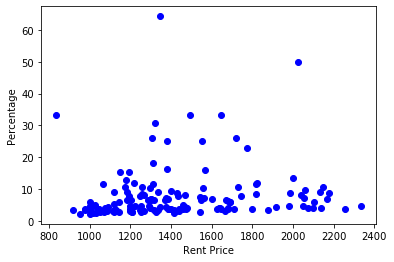

In [45]:
#Let's make a scatter plot to see whether we can spot a linear correlation between fast food restaurant ratios and median housing prices.
plt.scatter(lafastpricena.Rent_Price, lafastpricena.Percentage, color='blue')
plt.xlabel("Rent Price")
plt.ylabel("Percentage")
plt.show()

#### It seems there is no linear relation between the number of fast food restaurants and rent prices in Los Angeles.

###### It's pretty much obvious that it won't be very easy to come up with a linear, non-linear, or polynomial regression model to explain any relationship between the number of fast food restaurants and rent prices.
###### So now we will try to use an unsupervised Machine Learning algorithm called K-Means clustering to put all the data into 5 different clusters.

In [46]:
# set number of clusters
kclusters = 5

lafastpricena_clustering = lafastpricena.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lafastpricena_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 3, 2, 4, 4, 0, 4, 3, 0], dtype=int32)

In [47]:
lafastpricena.head()

Neighborhood   Latitude   Longitude   Rent_Price  Percentage
0         Acton  34.497483 -118.206372  1647.500000   33.333333
2  Agoura Hills  34.155534 -118.765098  2052.500000    7.142857
4      Alhambra  34.084448 -118.135322  1205.564286    4.000000
5  Alondra Park  33.885925 -118.335435  1667.142857    2.941176
6      Altadena  34.190096 -118.136334  1458.321429    5.000000

In [48]:
# add clustering labels
lafastpricena.insert(0, 'Cluster Labels', kmeans.labels_)
lafastpricena.head() # check the last columns!

Cluster Labels  Neighborhood   Latitude   Longitude   Rent_Price  \
0               2         Acton  34.497483 -118.206372  1647.500000   
2               1  Agoura Hills  34.155534 -118.765098  2052.500000   
4               3      Alhambra  34.084448 -118.135322  1205.564286   
5               2  Alondra Park  33.885925 -118.335435  1667.142857   
6               4      Altadena  34.190096 -118.136334  1458.321429   

   Percentage  
0   33.333333  
2    7.142857  
4    4.000000  
5    2.941176  
6    5.000000

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lafastpricena['Latitude'], lafastpricena['Longitude'], lafastpricena['Neighborhood'], lafastpricena['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 0

In [50]:
cluster_0 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 0, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_0 = cluster_0.sort_values(by=['Rent_Price'], ascending=False)
cluster_0

Neighborhood   Rent_Price  Percentage
121                       Lancaster  1151.751323   15.384615
95                        Hawthorne  1145.476190    2.631579
90                      Harbor City  1143.551020    5.882353
173                Rancho Dominguez  1135.285714    3.225806
146                   Monterey Park  1132.053571    3.030303
106                       Inglewood  1124.936170    3.846154
80                          Gardena  1121.790476    2.857143
62                     East Compton  1120.428571    9.090909
98                    Highland Park  1119.428571    5.263158
52                           Cudahy  1114.476190    3.225806
198                  South El Monte  1092.380952    4.255319
21                     Bell Gardens  1085.761905    3.225806
202               South San Gabriel  1075.761905    3.921569
196                     Signal Hill  1070.000000    2.777778
132                         Lynwood  1065.597403   11.428571
134               Manchester Square  1061.000000    3.125000
50                          Compton  1048.958333    2.777778
104                       Hyde Park  1044.771429    3.703704
44              Chesterfield Square  1043.190476    3.703704
84                    Gramercy Park  1033.428571    2.325581
124                    Leimert Park  1025.571429    5.000000
91                   Harbor Gateway  1017.232143    2.500000
238                      West Adams  1013.523810    4.347826
199                      South Gate  1004.081633    6.060606
20                             Bell  1002.346939    3.448276
240                    West Compton  1000.142857    2.272727
17           Baldwin Hills/Crenshaw  1000.102041    4.761905
125                          Lennox   977.685714    3.571429
139                         Maywood   976.510204    3.333333
12                           Athens   953.571429    2.173913
49                         Commerce   915.952381    3.333333
218  Unincorporated Catalina Island   835.428571   33.333333

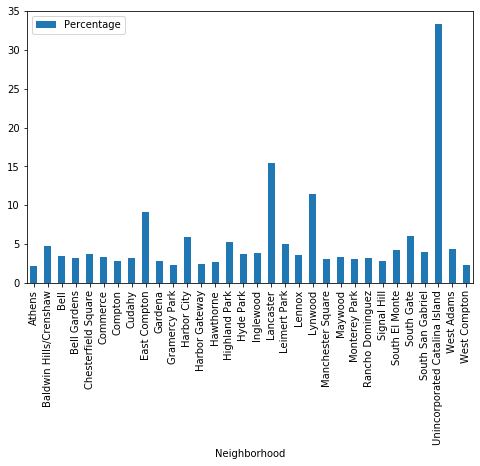

In [51]:
cluster_0 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 0, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_00 = cluster_0[['Neighborhood','Percentage']]
cluster_00.set_index('Neighborhood', inplace=True)
cluster_00.plot(kind='bar', figsize=(8, 5))

### Cluster 1

In [52]:
cluster_1 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 1, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_1 = cluster_1.sort_values(by=['Rent_Price'], ascending=False)
cluster_1

Neighborhood   Rent_Price  Percentage
186                             San Marino  2332.384615    4.761905
160                   Palos Verdes Estates  2256.380952    3.846154
170                           Porter Ranch  2179.347826    8.695652
28                                Bradbury  2166.428571    6.896552
249                       Westlake Village  2147.357143   10.714286
137                         Marina del Rey  2137.571429    4.166667
36                                 Castaic  2132.400000    9.090909
206                        Stevenson Ranch  2104.857143    5.882353
219  Unincorporated Santa Monica Mountains  2100.020408    4.166667
179                          Rolling Hills  2076.333333    4.166667
32                               Calabasas  2061.190476    9.523810
2                             Agoura Hills  2052.500000    7.142857
242                             West Hills  2049.068493    4.761905
235                                 Walnut  2038.026316    8.000000
126                           Leona Valley  2024.000000   50.000000
112                       La Habra Heights  2001.333333   13.333333
40                                Cerritos  1983.155844    8.823529
258                         Woodland Hills  1982.222222    4.545455
168                          Playa del Rey  1914.571429    4.347826

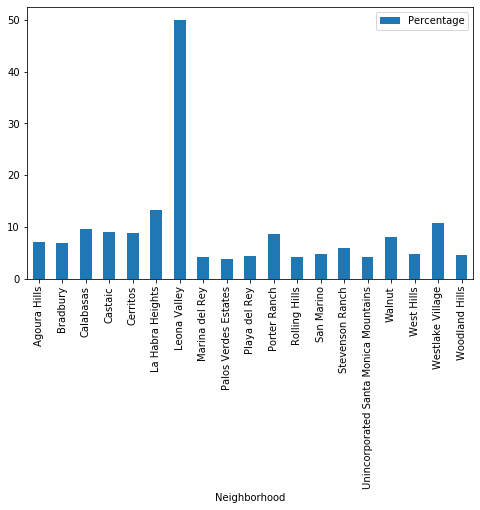

In [53]:
cluster_1 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 1, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_11 = cluster_1[['Neighborhood','Percentage']]
cluster_11.set_index('Neighborhood', inplace=True)
cluster_11.plot(kind='bar', figsize=(8, 5))

### Cluster 2

In [54]:
cluster_2 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 2, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_2 = cluster_2.sort_values(by=['Rent_Price'], ascending=False)
cluster_2

Neighborhood   Rent_Price  Percentage
96                           Hermosa Beach  1877.628571    3.333333
97                            Hidden Hills  1822.571429   11.764706
85                           Granada Hills  1818.312500   11.538462
180                  Rolling Hills Estates  1816.222222    8.333333
57                             Diamond Bar  1796.920635    3.846154
172                                 Ramona  1776.142857   22.727273
43                    Chatsworth Reservoir  1743.285714    7.692308
42                              Chatsworth  1727.486486   10.714286
183                              San Dimas  1720.267857   26.086957
193                           Shadow Hills  1708.642857    3.703704
220  Unincorporated Santa Susana Mountains  1692.285714    5.882353
176                          Redondo Beach  1688.604396    6.060606
247                            Westchester  1682.311688    3.571429
167                            Playa Vista  1679.642857    4.000000
88                        Hacienda Heights  1678.582418    6.250000
182                        Rowland Heights  1671.640000    6.451613
5                             Alondra Park  1667.142857    2.941176
0                                    Acton  1647.500000   33.333333
195                           Sierra Madre  1646.571429    3.703704
175                            Rancho Park  1643.285714    4.000000
116                         Ladera Heights  1637.678571    4.000000
189                          Santa Clarita  1627.213523    3.846154
105                               Industry  1600.122449    6.896552

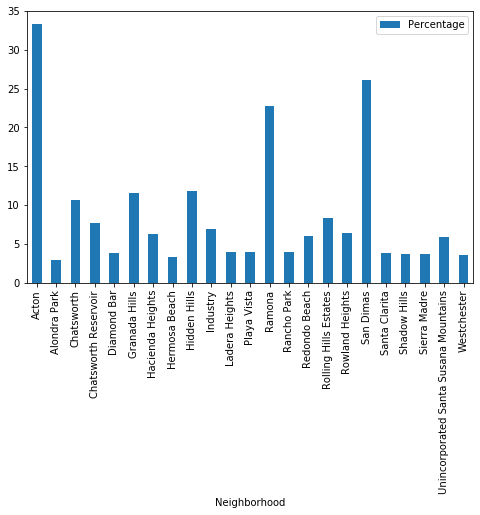

In [55]:
cluster_2 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 2, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_22 = cluster_2[['Neighborhood','Percentage']]
cluster_22.set_index('Neighborhood', inplace=True)
cluster_22.plot(kind='bar', figsize=(8, 5))

### Cluster 3

In [56]:
cluster_3 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 3, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_3 = cluster_3.sort_values(by=['Rent_Price'], ascending=False)
cluster_3

Neighborhood   Rent_Price  Percentage
205  Southeast Antelope Valley  1347.100000   64.285714
187                San Pasqual  1345.785714    4.347826
51                      Covina  1338.542857    9.090909
142              Mission Hills  1337.371429    3.333333
123                   Lawndale  1324.714286    2.777778
185                San Gabriel  1324.492063    3.225806
158                   Palmdale  1320.727679   30.769231
177                     Reseda  1317.252747    3.448276
190           Santa Fe Springs  1316.333333    6.666667
252                   Whittier  1313.341270   18.181818
204             South Whittier  1309.307692   11.538462
154         Northwest Palmdale  1304.428571   26.086957
246   West Whittier-Los Nietos  1301.309524    6.666667
222                    Valinda  1300.666667    6.896552
130        Lopez/Kagel Canyons  1300.285714    6.896552
66               East Pasadena  1297.857143    4.000000
164                Pico Rivera  1296.076923   10.344828
253           Whittier Narrows  1293.142857    4.651163
245         West Puente Valley  1288.600000    6.666667
128                     Lomita  1268.857143    3.125000
188                  San Pedro  1267.883117    8.000000
58                      Downey  1259.000000    8.333333
16                       Azusa  1255.842857   10.714286
233    View Park-Windsor Hills  1253.714286    3.448276
239                West Carson  1251.178571    2.702703
33                 Canoga Park  1250.233333    4.761905
60                      Duarte  1247.857143    3.333333
184               San Fernando  1246.714286    7.692308
169                     Pomona  1223.936275    4.761905
47                      Citrus  1216.095238   12.000000
129                 Long Beach  1210.166891    2.777778
181                   Rosemead  1206.181818    2.857143
4                     Alhambra  1205.564286    4.000000
119          Lake View Terrace  1205.000000    6.451613
64              East La Mirada  1200.214286    3.125000
257                   Winnetka  1197.922078    4.545455
107                  Irwindale  1196.285714    3.846154
114                  La Puente  1195.125000    7.692308
171                Quartz Hill  1191.785714   15.384615
94            Hawaiian Gardens  1185.214286    9.090909
144                 Montebello  1185.153061    6.666667
22                  Bellflower  1178.880952   12.903226
162                  Paramount  1171.942857   10.714286

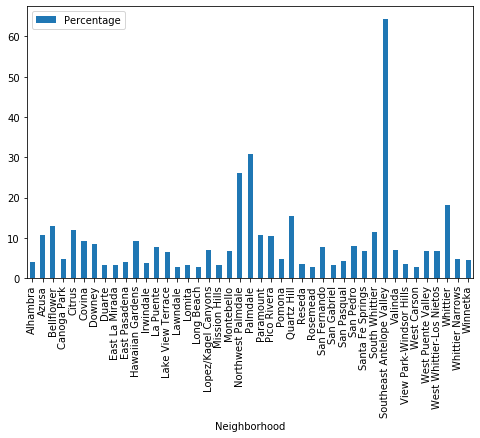

In [57]:
cluster_3 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 3, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_33 = cluster_3[['Neighborhood','Percentage']]
cluster_33.set_index('Neighborhood', inplace=True)
cluster_33.plot(kind='bar', figsize=(8, 5))

### Cluster 4

In [58]:
cluster_4 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 4, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_4 = cluster_4.sort_values(by=['Rent_Price'], ascending=False)
cluster_4

Neighborhood   Rent_Price  Percentage
115                   La Verne  1566.836735   16.000000
150             North Whittier  1560.571429    7.142857
120                   Lakewood  1555.817460   10.344828
83                    Glendora  1552.681319   25.000000
215                   Torrance  1548.619048    6.666667
37             Castaic Canyons  1547.709677    7.142857
117                Lake Balboa  1544.857143    2.857143
113                  La Mirada  1543.242857    7.407407
153  Northwest Antelope Valley  1494.428571   33.333333
56                     Del Rey  1478.163265    4.166667
53                 Culver City  1473.734694    3.703704
241                West Covina  1468.093168    8.000000
163                   Pasadena  1467.540084    4.347826
136                  Mar Vista  1459.442857    3.703704
6                     Altadena  1458.321429    5.000000
67            East San Gabriel  1439.542857    3.125000
209                    Sunland  1437.619048    3.703704
152                 Northridge  1435.612245    7.692308
210                     Sylmar  1427.904762    8.695652
201             South Pasadena  1426.628571    3.225806
143                   Monrovia  1416.071429    3.333333
34                      Carson  1413.742424    2.439024
11                     Artesia  1400.333333    9.375000
48                   Claremont  1399.678571    3.846154
159                      Palms  1390.233766    3.703704
203       South San Jose Hills  1386.114286    6.896552
212                Temple City  1383.081633    3.571429
41                 Charter Oak  1382.285714   25.000000
155                    Norwalk  1378.666667   16.129032
234                    Vincent  1374.714286    4.347826
148                North Hills  1373.360825    7.142857
15             Avocado Heights  1369.428571    6.451613

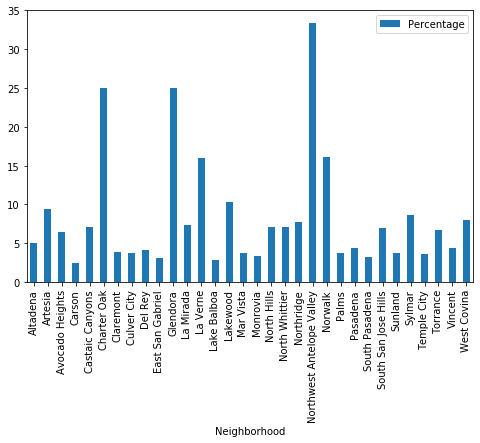

In [59]:
cluster_4 = lafastpricena.loc[lafastpricena['Cluster Labels'] == 4, lafastpricena.columns[[1,4] + list(range(5, lafastpricena.shape[1]))]]
cluster_44 = cluster_4[['Neighborhood','Percentage']]
cluster_44.set_index('Neighborhood', inplace=True)
cluster_44.plot(kind='bar', figsize=(8, 5))

In [60]:
la_geo = r'Los_Angeles_Neighborhood_Map.geojson' # geojson file

In [61]:
# create map
la_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# generate choropleth map using the percentage of Fast Food Restaurants over to other Restaurants in LA.
la_clusters.choropleth(
    geo_data=la_geo,
    data=lafastpricena,
    columns=['Neighborhood','Percentage'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Fast Food Restaurant Ratio')
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(lafastpricena['Latitude'], lafastpricena['Longitude'], lafastpricena['Neighborhood'], lafastpricena['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(la_clusters)

# display map
la_clusters

       

### 8. Evaluation - Final Report
##### Analysis of Clusters:

Cluster 0: In $1600-$1877 median rent price interval; Acton, Ramona, San Dimas, Chatsworth, and Hidden Hills come into prominence with 50%, 22.7%, 22.7%, 10.7% and 10% Fast Food Restaurant ratios over other restaurants respectively.
Cluster 1: In $1171-$1347 median rent price interval; SE Antelope Valley, Palmdale, Northwest Palmdale, and Whittier come into prominence with 67%, 30%, 20% and 20% Fast Food Restaurant ratios over other restaurants respectively.
Cluster 2: In $1369-$1566 median rent price interval; Northwest Antelope Valley, Chatter Oak, Glendora, Norwalk, and Verne come into prominence with 33%, 25%, 25%, 13%  Fast Food Restaurant ratios over other restaurants respectively.
Cluster 3: In $1914-$2332 median rent price interval; Leona Valley, La Habra Heights, and Westlake step forward with 50%, 13%, 13%, Fast Food Restaurant ratios over other restaurants respectively.
Cluster 4: In $835-$1151 median rent price interval; Catalina Island, Lancaster, Lynwood, and East Compton step aside with 33%, 14.8%, 9.7%, and 9.4% Fast Food Restaurant ratios over other restaurants respectively.

Discussion and Final Thoughts:

To have a better visual image of what’s going on, I plotted a choropleth map using Folium library of Python to see the big picture. A short glance at the map shows us that Fast Food/Other Restaurants ratio vary from 2% to 65%. When clusters analyzed, Cluster 1 has more fast food restaurant presence than other clusters as eight neighborhoods exceed 10% Fast Food restaurant ratio threshold. If you clearly look into the map above though, downtown area where population is supposed to be higher is out of any cluster. This is mainly due to Foursquare having more non-restaurant venues over those areas and even a very high number of venue call as 10k isn’t enough to filter only restaurants to have a better understanding of the fast food environment in LA. I think the best approach is to start analyzing non-mathematical facts of the locations in Cluster 1 and 4 with higher presence of Fast Food Restaurants using a top down approach, and see whether social facts have any influence on changing decisions. For instance the top location in Cluster 1 is SE Antelope Valley and that probably has something to do with it being a tourist location. Opening the first restaurant far out of the city at a tourist location can be a very tricky business decision. All in all the map above and clusters give a good idea on where to start the search in terms of fast food culture and comparative rent costings.